In [76]:
#loading the important libraries for Exploratory Data Ananlysis.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score , classification_report, ConfusionMatrixDisplay,precision_score,recall_score, f1_score,roc_auc_score,roc_curve, balanced_accuracy_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC

In [2]:
#reading the dataset
brain = pd.read_csv("D:/New downloads/stroke_data/brain_stroke.csv")
brain.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [3]:
#shape of the data
brain.shape

(4981, 11)

In [84]:
brain['stroke'].value_counts()

0    3280
1     201
Name: stroke, dtype: int64

In [4]:
#checking for NA values in the dataset
brain.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [5]:
#checking basic info about the data-set
brain.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [6]:
# Now, we will try to convert the categorical data into binary data which will help us in visualizing on the data well and it will computationally less expensive for us when we try to train our models on this dataset.

In [7]:
brain["gender"].unique() #checking the unique values in the column "gender"
# Here, Male can be mapped to 1 and Female can be mapped to 0.

array(['Male', 'Female'], dtype=object)

In [8]:
brain["gender"] = brain["gender"].map({"Male":1, "Female":0})

In [9]:
#Similarly, we will check for other columns!

In [10]:
brain["work_type"].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children'], dtype=object)

In [12]:
brain["Residence_type"].unique()

array(['Urban', 'Rural'], dtype=object)

In [13]:
# Convert them as Urban = 1 and Rural as 0
brain["Residence_type"] = brain["Residence_type"].map({"Urban":1, "Rural":0})

In [15]:
brain["ever_married"].unique()

array(['Yes', 'No'], dtype=object)

In [16]:
# Yes can be mapped to 1 and no can be mapped to 0.
brain["ever_married"] = brain["ever_married"].map({"Yes":1, "No":0})

In [17]:
brain.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
2,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
3,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
4,1,81.0,0,0,1,Private,1,186.21,29.0,formerly smoked,1


In [11]:
brain["smoking_status"].unique()
#We have identified that the "smoking_status" column has four unique values, including "Unknown." It is prudent to exclude rows with unknown smoking status from our model training since predicting outcomes for individuals without smoking status information lacks meaningful input. Additionally, retaining such unknown values might introduce noise and compromise the model's predictive accuracy, emphasizing the importance of removing these instances.As Four unique values are present, we can't change it to Binary values. Thus we will leave it as it is.

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [18]:
# #counting the number of Unknowns in the "smoke_staus"
unknown_count = brain['smoking_status'].value_counts().get('Unknown', 0)
print(f"Number of 'Unknown' in smoking_status: {unknown_count}")

Number of 'Unknown' in smoking_status: 1500


In [19]:
# We will now remove these 1500 rows!
brain = brain[brain['smoking_status'] != 'Unknown']

# Resetting the index
brain.reset_index(drop=True, inplace=True)
brain["smoking_status"].unique()

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

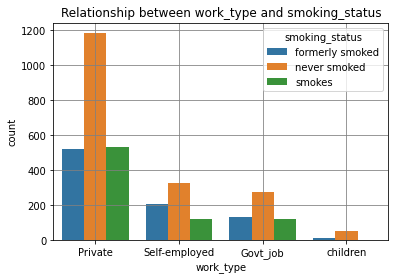

In [20]:
plt.figure()
sns.countplot(x='work_type', hue='smoking_status', data=brain)
plt.title('Relationship between work_type and smoking_status')
plt.grid(color = "gray")
plt.show()

In [21]:
# The bar chart depicts the correlation between 'work_type' and 'smoking_status'. It features four bars (private, self-employed, government, and children), each divided into three sections (smokes, formerly smoked, and never smoked). The y-axis represents the count of individuals, while the x-axis represents work types. Notably, individuals in the private sector are more likely to smoke, with approximately 500 people, and have almost equal incidence of past smoking compared to other sectors. Self-employed and government workers show lower smoking counts and a proportionally smaller "formerly smoked" segment. Children exhibit the least smoking prevalence.

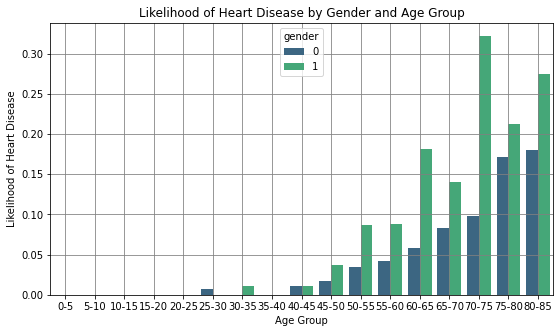

In [22]:
bins = range(0, int(brain['age'].max()) + 6, 5)
labels = [f'{start}-{end}' for start, end in zip(bins[:-1], bins[1:])]
brain['age_group'] = pd.cut(brain['age'], bins=bins, labels=labels, right=False)

# Grouping by 'gender' and 'age_group' and calculating the mean of 'heart_disease'
grouped_data = brain.groupby(['gender', 'age_group'])['heart_disease'].mean().reset_index()

# Creating a bar plot
plt.figure(figsize=(9, 5))
sns.barplot(x='age_group', y='heart_disease', hue='gender', data=grouped_data, palette='viridis')
plt.title('Likelihood of Heart Disease by Gender and Age Group')
plt.xlabel('Age Group')
plt.ylabel('Likelihood of Heart Disease')
plt.grid(color = "gray")
plt.show()

In [41]:
brain = brain.drop("age_group", axis = 1)

In [23]:
# The graph shows that the likelihood of heart disease increases with age for both males and females, but it is higher for males than for females at all ages. The likelihood of heart disease is also highest for males in the 70-75 age group and for females in the 80-85 age group.

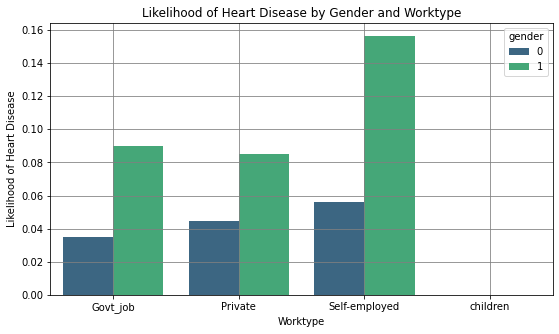

In [24]:
grouped_data = brain.groupby(['gender', 'work_type'])['heart_disease'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(9, 5))
sns.barplot(x='work_type', y='heart_disease', hue='gender', data=grouped_data, palette='viridis')
plt.title('Likelihood of Heart Disease by Gender and Worktype')
plt.xlabel('Worktype')
plt.ylabel('Likelihood of Heart Disease')
plt.grid(color = "gray")
plt.show()

In [25]:
# The graph shows that the likelihood of heart disease is higher for people who are self-employed than for people who work in government jobs or private sector jobs. The likelihood of heart disease is also higher for males than for females in all work types.

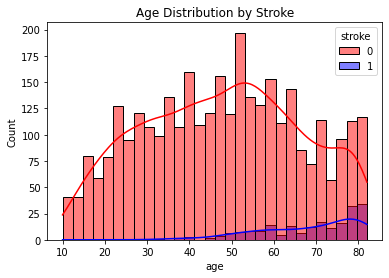

In [26]:
plt.figure()
sns.histplot(x='age', hue='stroke', data=brain, kde=True, bins=30, palette=['red', 'blue'])
plt.title('Age Distribution by Stroke')

plt.show()

In [27]:
# The plot shows that the age distribution of stroke patients is skewed to the right, meaning that there are more older stroke patients than younger stroke patients. The median age of stroke patients in the dataset is 65 years old. Patients with a history of stroke are also more likely to be older than patients without a history of stroke.

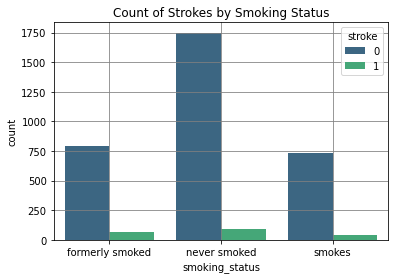

In [28]:
sns.countplot(x='smoking_status', hue='stroke', data=brain, palette='viridis')
plt.title('Count of Strokes by Smoking Status')
plt.grid(color = "gray")
plt.show()

In [ ]:
# It's unexpected to observe that the likelihood of experiencing a stroke is not much influenced by an individual's smoking status. Despite this, it can be deduced that individuals who have never smoked exhibit a lower susceptibility to stroke.

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [35]:
brain = pd.get_dummies(brain,columns=['work_type','Residence_type','smoking_status'])

In [42]:
X = brain.drop(['stroke'],axis=1)
y = brain['stroke']

In [43]:
brain

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_0,Residence_type_1,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,228.69,36.6,1,0,1,0,0,0,1,1,0,0
1,1,80.0,0,1,1,105.92,32.5,1,0,1,0,0,1,0,0,1,0
2,0,49.0,0,0,1,171.23,34.4,1,0,1,0,0,0,1,0,0,1
3,0,79.0,1,0,1,174.12,24.0,1,0,0,1,0,1,0,0,1,0
4,1,81.0,0,0,1,186.21,29.0,1,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476,1,41.0,0,0,0,70.15,29.8,0,0,1,0,0,1,0,1,0,0
3477,1,40.0,0,0,1,191.15,31.1,0,0,1,0,0,0,1,0,0,1
3478,0,45.0,1,0,1,95.02,31.8,0,1,0,0,0,1,0,0,0,1
3479,1,40.0,0,0,1,83.94,30.0,0,0,1,0,0,1,0,0,0,1


In [44]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.25,random_state=3)

In [45]:
dec_clf=DecisionTreeClassifier(criterion='gini',random_state=3,max_depth=5)
dec_clf.fit(X_train,y_train)
y_pred=dec_clf.predict(X_test)

In [46]:
print('Training-set accuracy score:', dec_clf.score(X_train, y_train))
print('Test-set accuracy score:', dec_clf.score(X_test, y_test))

Training-set accuracy score: 0.9467432950191571
Test-set accuracy score: 0.939150401836969


C:\Users\Hari\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


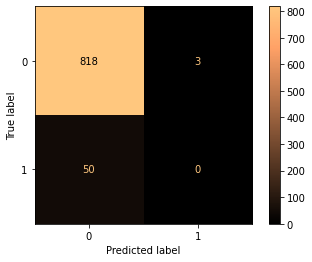

In [66]:
plot_confusion_matrix(dec_clf,X_test,y_test,cmap = "copper")

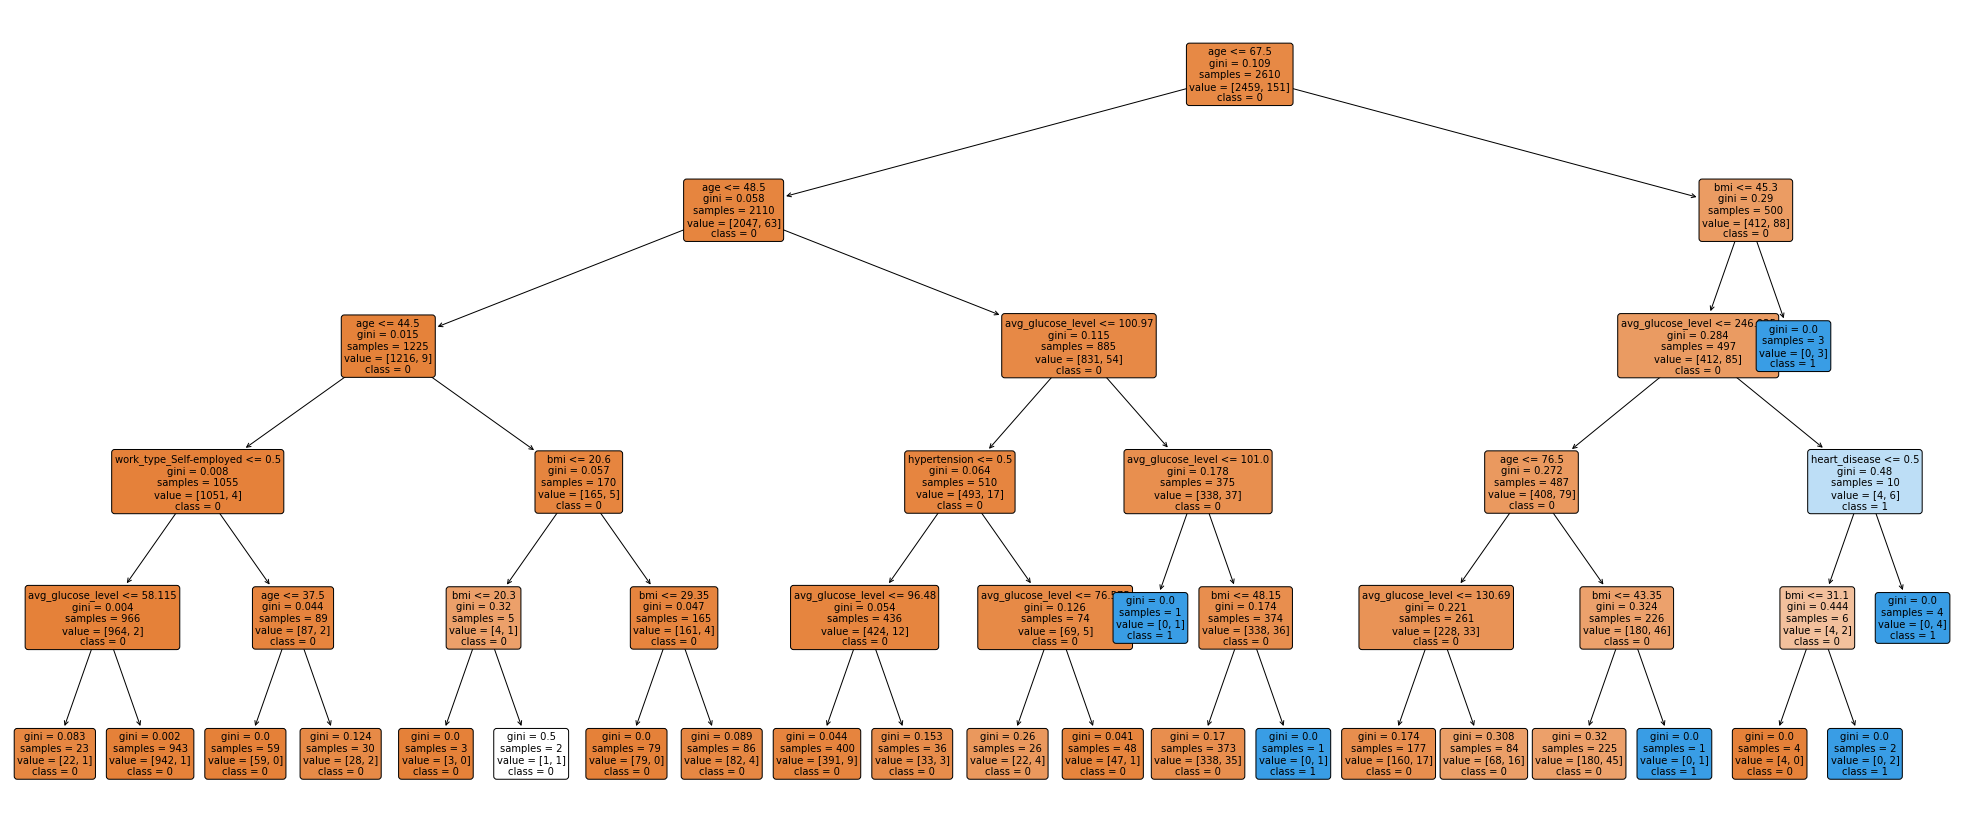

In [103]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Visualize the decision tree

plt.figure(figsize=(35, 15))
plot_tree(dec_clf, feature_names=X_train.columns, class_names=['0', '1'], filled=True, rounded=True, fontsize=10)
plt.show()

In [68]:
def train_evaluate_model(y_test, predictions):
    #compute metrics for evaluation
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)

    #create a dataframe to visualize the results
    eval_df = pd.DataFrame([[accuracy, f1, precision, recall, balanced_accuracy, auc]], columns=['accuracy', 'f1_score', 'precision', 'recall', 'balanced_accuracy', 'auc'])
    return eval_df

In [88]:
results = train_evaluate_model(y_test, y_pred)
results.index = ['Decision tree classifier']

In [89]:
results

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Decision tree classifier,0.93915,0.0,0.0,0.0,0.498173,0.498173


In [77]:
param_grid = {'C': [1,10,100,1000], 
                'gamma': [1, 0.1, 0.01, 0.001],
                'kernel': ['rbf']} 
    
gridSVM = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=2)
    
# fitting the model for grid search
gridSVM.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END ..........C=1, gamma=1, kernel=rbf;, score=0.943 total time=   2.6s
[CV 2/2] END ..........C=1, gamma=1, kernel=rbf;, score=0.942 total time=   2.4s
[CV 1/2] END ........C=1, gamma=0.1, kernel=rbf;, score=0.943 total time=   2.1s
[CV 2/2] END ........C=1, gamma=0.1, kernel=rbf;, score=0.942 total time=   2.2s
[CV 1/2] END .......C=1, gamma=0.01, kernel=rbf;, score=0.942 total time=   0.6s
[CV 2/2] END .......C=1, gamma=0.01, kernel=rbf;, score=0.942 total time=   0.6s
[CV 1/2] END ......C=1, gamma=0.001, kernel=rbf;, score=0.941 total time=   0.4s
[CV 2/2] END ......C=1, gamma=0.001, kernel=rbf;, score=0.942 total time=   0.4s
[CV 1/2] END .........C=10, gamma=1, kernel=rbf;, score=0.943 total time=   2.5s
[CV 2/2] END .........C=10, gamma=1, kernel=rbf;, score=0.942 total time=   2.4s
[CV 1/2] END .......C=10, gamma=0.1, kernel=rbf;, score=0.935 total time=   2.1s
[CV 2/2] END .......C=10, gamma=0.1, kernel=rbf;

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [78]:
print(gridSVM.best_params_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [79]:
y_pred_test = gridSVM.predict(X_test)
y_pred_train = gridSVM.predict(X_train)

In [80]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

1.0
0.9425947187141217


C:\Users\Hari\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


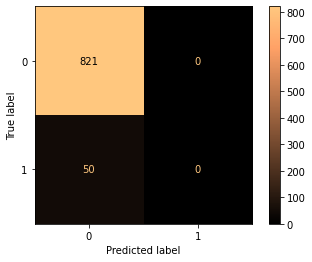

In [82]:
plot_confusion_matrix(gridSVM,X_test,y_test,cmap = "copper")

In [90]:
resultsSVM = train_evaluate_model(y_test, y_pred_test)
resultsSVM.index = ['Support Vector Machine']
results = results.append(resultsSVM)

C:\Users\Hari\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
results

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Decision tree classifier,0.939150,0.0,0.0,0.0,0.498173,0.498173
Support Vector Machine,0.942595,0.0,0.0,0.0,0.500000,0.500000
